# Predicting Brexit vote based on early counts

The idea: as votes are coming in, can we use them to predict the probability the outcome of referendum?

Without any data except for raw counts, we make the simplifying assumption that for each district the probability of voting "leave" is independently drawn from a Beta(a, b) distribution.

Note: this code was written real-time so nothing fancy. Based on data available at 6:54PM Pacific time on night of referendum.

In [1]:
import random

import numpy as np
import scipy as sp
import pandas as pd

import scipy.stats

import pystan as ps

%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set_context('notebook')

import toyplot as tp
import toyplot.svg

In [2]:
df = pd.read_csv("brexit-data/data654pm.csv")

print(len(df))

75


In [3]:
df["total"] = df["leave"] + df["remain"]
df["frac_leave"] = df["leave"] / df["total"]

In [4]:
# remove gibraltar outlier
df = df[~df.area.str.contains("gibraltar")]

In [5]:
df.head(10)

,area,leave,remain,total,frac_leave
0,angus,26511,32747,59258,0.447383
1,basildon,67251,30748,97999,0.686242
2,belfast west,8092,23099,31191,0.259434
3,blaenau gwent,21587,13215,34802,0.620280
4,brentwood,27627,19077,46704,0.591534
5,broxbourne,33706,17166,50872,0.662565
6,bury,54674,46354,101028,0.541177
7,caerphilly,53295,39178,92473,0.576330
8,city of london,1087,3312,4399,0.247102
9,clackmannanshire,10736,14691,25427,0.422228


In [6]:
canvas = tp.Canvas(600, 350)
axes = canvas.cartesian(label="Rseults of early votes by district", xlabel="# of votes (x1000)", ylabel="% leave")
axes.scatterplot(df["total"]/1000, df["leave"]/df["total"])
axes.hlines([0.5], color="grey")
axes.x.ticks.show = True
axes.y.ticks.show = True
axes.y.ticks.locator = tp.locator.Explicit(locations=np.linspace(0, 1, 11))

# svg = toyplot.svg.render(canvas, "plots/early_results_scatter.svg")

0 50 100 150 # of votes (x1000) 0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1 % leave Rseults of early votes by district 
 
 
 Save as .csv

In [7]:
canvas = tp.Canvas(600, 350)
axes = canvas.cartesian(xlabel="Count", ylabel="% Leave")
axes.bars(np.histogram(df["leave"] / df["total"], bins=10))

0.2 0.3 0.4 0.5 0.6 0.7 Count 0 4 8 12 % Leave 
 
 
 Save as .csv

In [8]:
total_prob = df["leave"].sum() / df["total"].sum()
print("{:.2f}% votes to LEAVE out of counted votes".format(100*total_prob))
print("total votes: {} - {} \t total: {} from {} districts".format(df.leave.sum(), 
                                                                   df.remain.sum(), 
                                                                   df.total.sum(),
                                                                   len(df)))

(df.leave.sum() - 0.5 * df.total.sum()) / np.sqrt(2 * df.total.sum())

50.49% votes to LEAVE out of counted votes
total votes: 2322145 - 2277443 	 total: 4599588 from 74 districts


7.3692365014590147

In [9]:
simple_model = """
data {
    int K;
    int total[K];
    int vote_leave[K];
}
parameters {
    real<lower=1> alpha;
    real<lower=1> beta;
    real<lower=0, upper=1> p[K];
}
model {
    for (i in 1:K) {
        p[i] ~ beta(alpha, beta);
        vote_leave[i] ~ binomial(total[i], p[i]);
    }
}
"""


In [10]:
data = {'K': len(df),
               'total': df["total"],
               'vote_leave': df["leave"]}

fit = ps.stan(model_code=simple_model, 
                         data=data, iter=5000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_06cb351dc5ee48e12e772cb1516dd478 NOW.


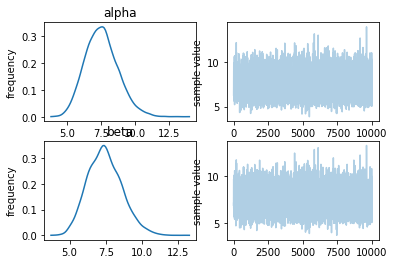

In [11]:
fit.plot(pars=['alpha', 'beta']);

In [12]:
overall_outcomes = fit["alpha"] / (fit["alpha"] + fit["beta"])

In [13]:
outcomes = []
for alpha, beta in zip(fit["alpha"], fit["beta"]):
    # new outcomes
    populations = np.random.choice(df["total"], size=len(df))
    p_leaves = [random.betavariate(alpha, beta) for _ in populations]
    leave_votes = [np.random.binomial(pop, prob) for pop, prob in zip(populations, p_leaves)]

    total_votes = sum(populations)
    total_leave = sum(leave_votes)
    outcomes.append(total_leave / total_votes)

In [14]:
canvas = tp.Canvas(600, 350)
axes = canvas.cartesian(label="Posterior for P(leave)", xlabel="% votes to leave", ylabel="density")
axes.bars(np.histogram(outcomes, bins=100, normed=True))
axes.vlines([0.5])

axes.x.ticks.show = True
axes.y.ticks.show = True

# svg = toyplot.svg.render(canvas, "plots/monte_carlo_results.svg")

0.45 0.50 0.55 0.60 % votes to leave 0 10 20 density Posterior for P(leave) 
 
 
 Save as .csv

In [15]:
canvas = tp.Canvas(600, 350)
axes = canvas.cartesian(label="Density of posterior for leave", xlabel="% votes to leave", ylabel="density")
axes.vlines([0.5], color="grey")

axes.scatterplot(df.frac_leave, [0.05 for _ in range(len(df))], marker="|", color="black", size=10)

x = np.linspace(0, 1, 100)

for alpha, beta in zip(fit["alpha"], fit["beta"]):
    if random.random() < 0.02:
        axes.plot(x, sp.stats.beta.pdf(x, alpha, beta), color="steelblue", opacity=0.1)

<path d="M 50.0 300.0 L 55.050505050505052 299.99999997516744 L 60.101010101010104 299.9999969144589 L 65.151515151515156 299.99994973959735 L 70.202020202020208 299.99964384012247 L 75.25252525252526 299.99840103016703 L 80.303030303030312 299.99462319306377 L 85.353535353535364 299.98519252275582 L 90.404040404040416 299.96477449172045 L 95.454545454545453 299.92508299348418 L 100.50505050505052 299.85417228771496 L 105.55555555555556 299.73581912119084 L 110.60606060606061 299.54905226961563 L 115.65656565656568 299.26787713251548 L 120.70707070707071 298.86123112676358 L 125.75757575757575 298.29319249833026 L 130.80808080808083 297.52345167376677 L 135.85858585858585 296.50804111319383 L 140.90909090909091 295.20030737132879 L 145.95959595959596 293.55209815710674 L 151.01010101010104 291.51512792219455 L 156.06060606060606 289.04247811523652 L 161.11111111111111 286.09018283036693 L 166.16161616161617 282.61884719305834 L 171.21212121212122 278.59524443241372 L 176.26262626262627 273.99383809706831 L 181.31313131313132 268.79817814466298 L 186.3636363636364 263.00212349685228 L 191.41414141414143 256.61084889820404 L 196.46464646464648 249.64160032217868 L 201.5151515151515 242.12417049112483 L 206.56565656565658 234.10107407356418 L 211.61616161616163 225.62741054400567 L 216.66666666666669 216.77041129595548 L 221.71717171717174 207.60867615515923 L 226.76767676767679 198.23111272867914 L 231.81818181818181 188.73559984479601 L 236.86868686868689 179.22740350789005 L 241.91919191919192 169.81738015306806 L 246.969696969697 160.62000740361137 L 252.02020202020205 151.75128690247243 L 257.0707070707071 143.32656702595548 L 262.12121212121212 135.45833533934882 L 267.17171717171721 128.25403149368896 L 272.22222222222223 121.81393088958252 L 277.27272727272731 116.22914787332323 L 282.32323232323233 111.5798045321217 L 287.37373737373741 107.93340739164091 L 292.42424242424244 105.34346958383335 L 297.47474747474746 103.84841045879344 L 302.52525252525254 103.47075829007341 L 307.57575757575762 104.21667481177562 L 312.62626262626264 106.07581298207998 L 317.67676767676767 109.02151175455512 L 322.7272727272728 113.01132392390147 L 327.77777777777777 117.98786546732811 L 332.82828282828285 123.87996739663532 L 337.87878787878788 130.60410413542712 L 342.92929292929296 138.06606600014555 L 347.97979797979804 146.16283764226026 L 353.030303030303 154.78463943874968 L 358.08080808080808 163.81708492010384 L 363.13131313131316 173.14340450243543 L 368.18181818181824 182.64668412523514 L 373.23232323232327 192.21206694833381 L 378.28282828282829 201.72886706547513 L 383.33333333333337 211.0925462558931 L 388.38383838383839 220.2065081000944 L 393.43434343434348 228.98366828375137 L 398.4848484848485 237.34776552723807 L 403.53535353535364 245.23438420178766 L 408.5858585858586 252.59166719177071 L 413.63636363636363 259.38070577377857 L 418.68686868686871 265.57560201851589 L 423.73737373737379 271.1632082684776 L 428.78787878787887 276.14255736939992 L 433.83838383838383 280.52400628530711 L 438.88888888888886 284.32812424098927 L 443.93939393939399 287.58436433898493 L 448.98989898989902 290.3295644151151 L 454.0404040404041 292.60632845604761 L 459.09090909090907 294.46134394484699 L 464.1414141414142 295.94369278702715 L 469.19191919191923 297.1032137914317 L 474.24242424242425 297.98897286930992 L 479.29292929292933 298.6478930559602 L 484.34343434343441 299.12359010281011 L 489.39393939393943 299.45545076459194 L 494.44444444444446 299.67798014318117 L 499.49494949494954 299.82043178692942 L 504.54545454545462 299.90672005453263 L 509.59595959595964 299.95559906147486 L 514.64646464646466 299.98107703686929 L 519.69696969696975 299.99302003274045 L 524.74747474747483 299.99788578026613 L 529.79797979797979 299.99951847483061 L 534.84848484848487 299.99993009180588 L 539.89898989898995 299.99999553494087 L 544.94949494949492 299.99999996157601 L 550.0 300.0" style="stroke:rgb(27.5%,51%,70.6%);stroke-opacity:0.1;stroke-wid

In [16]:
prob_leave_wins = len(list(filter(lambda x: x>0.5, outcomes)))/len(outcomes)
print("Probability LEAVE wins: {:.2f}%".format(100*prob_leave_wins))

Probability LEAVE wins: 57.00%
